In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
%matplotlib inline
from sklearn.model_selection import train_test_split


In [4]:
data = pd.read_csv('/content/heart.csv')

In [5]:
data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [6]:
data.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

X = data.drop('output', axis =1)
target = data['output']

rfc = RandomForestClassifier(random_state=1)
rfecv = RFECV(estimator=rfc, step =1, cv =10, scoring = 'accuracy')

rfecv.fit(X, target)

RFECV(cv=10, estimator=RandomForestClassifier(random_state=1),
      scoring='accuracy')

In [8]:
print('Optimal Number of features is : {}'.format(rfecv.n_features_))


Optimal Number of features is : 11


In [9]:
print(np.where(rfecv.support_ == False)[0])


[5 6]


In [10]:
X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis =1 ,inplace=True)


In [11]:
X

,age,sex,cp,trtbps,chol,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,150,0,2.3,0,0,1
1,37,1,2,130,250,187,0,3.5,0,0,2
2,41,0,1,130,204,172,0,1.4,2,0,2
3,56,1,1,120,236,178,0,0.8,2,0,2
4,57,0,0,120,354,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,123,1,0.2,1,0,3
299,45,1,3,110,264,132,0,1.2,1,0,3
300,68,1,0,144,193,141,0,3.4,1,2,3
301,57,1,0,130,131,115,1,1.2,1,1,3


In [12]:
y = target

In [13]:
y.value_counts()

1    165
0    138
Name: output, dtype: int64

In [14]:
def remove_outliers(df):
    outliers = {}
    for col in df.columns:
        if str(df[col].dtype) != 'object':
            df = df[np.abs(df[col]-df[col].mean()) < (3*df[col].std())]
            olrs = df[~(np.abs(df[col]-df[col].mean()) < (3*df[col].std()))]
            outliers = pd.DataFrame(olrs)

    return print('These outliers have been removed from your dataset: \n\n', outliers,
                'New shape is:', df.shape)

In [15]:

### It will zero variance features
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(X)

VarianceThreshold(threshold=0)

In [16]:
constant_columns = [column for column in X.columns
                    if column not in X.columns[var_thres.get_support()]]

print(len(constant_columns))

0


In [17]:
remove_outliers(X)


These outliers have been removed from your dataset: 

 Empty DataFrame
Columns: [age, sex, cp, trtbps, chol, thalachh, exng, oldpeak, slp, caa, thall]
Index: [] New shape is: (287, 11)


In [18]:
num_features = X.select_dtypes(exclude = "object")
cat_features = X.select_dtypes(include = "object")

In [19]:
num_features

,age,sex,cp,trtbps,chol,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,150,0,2.3,0,0,1
1,37,1,2,130,250,187,0,3.5,0,0,2
2,41,0,1,130,204,172,0,1.4,2,0,2
3,56,1,1,120,236,178,0,0.8,2,0,2
4,57,0,0,120,354,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,123,1,0.2,1,0,3
299,45,1,3,110,264,132,0,1.2,1,0,3
300,68,1,0,144,193,141,0,3.4,1,2,3
301,57,1,0,130,131,115,1,1.2,1,1,3


In [20]:

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)


In [22]:
corr_features = correlation(X, 0.8)
len(set(corr_features))

0

In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLarsCV, RANSACRegressor, ElasticNet, Lasso, SGDClassifier,ARDRegression, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import HistGradientBoostingRegressor,BaggingRegressor, GradientBoostingRegressor

from sklearn.metrics import *
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier, ExtraTreesClassifier
)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from tabulate import tabulate  # Import the tabulate library


step1 = ColumnTransformer(
    transformers=[
        ('col_tnf', OneHotEncoder( sparse = False,drop='first', handle_unknown='ignore'),cat_features.columns),
        ('num_tnf', StandardScaler(), num_features.columns)
    ],
    remainder='passthrough'
)

In [24]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    pipe = Pipeline([
        ('Transform', step1),  # You need to define the 'step1' transformer
        ('model', model),
    ])

    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)

    # Use appropriate classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred,  average="macro")
    f1 = f1_score(y_test, y_pred,  average="macro")

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, cm

# Initialize different classification models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'Bagging Classifier': BaggingClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier(),
    'Support Vector Classifier': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
}

# Create a list to store the results
results = []

# Evaluate and print classification metrics for different models
for model_name, model in models.items():
    accuracy, precision, recall, f1, cm = evaluate_model(model, x_train, y_train, x_test, y_test)
    results.append([model_name, accuracy, precision, recall, f1, cm])

# Print the results in a tabular form
headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "Confusion Matrix"]
print(tabulate(results, headers, tablefmt="grid"))

max_accuracy_index = np.argmax([result[1] for result in results])
best_model_name = results[max_accuracy_index][0]
print(f"\nThe model with the highest accuracy is: {best_model_name} (Accuracy: {results[max_accuracy_index][1]:.4f})")

+------------------------------+------------+-------------+----------+------------+--------------------+
| Model                        |   Accuracy |   Precision |   Recall |   F1 Score | Confusion Matrix   |
+==============================+============+=============+==========+============+====================+
| Logistic Regression          |   0.868852 |    0.868534 | 0.868534 |   0.868534 | [[25  4]           |
|                              |            |             |          |            |  [ 4 28]]          |
+------------------------------+------------+-------------+----------+------------+--------------------+
| Random Forest Classifier     |   0.852459 |    0.852814 | 0.851293 |   0.851822 | [[24  5]           |
|                              |            |             |          |            |  [ 4 28]]          |
+------------------------------+------------+-------------+----------+------------+--------------------+
| Gradient Boosting Classifier |   0.770492 |    0.7743

+---------------------------+------------+-------------+----------+------------+--------------------+
| Model                     |   Accuracy |   Precision |   Recall |   F1 Score | Confusion Matrix   |
+===========================+============+=============+==========+============+====================+
| Support Vector Classifier |   0.901639 |    0.901401 | 0.901401 |   0.901401 | [[26  3]           |
|                           |            |             |          |            |  [ 3 29]]          |
+---------------------------+------------+-------------+----------+------------+--------------------+

The model with the highest accuracy is: Support Vector Classifier (Accuracy: 0.9016)


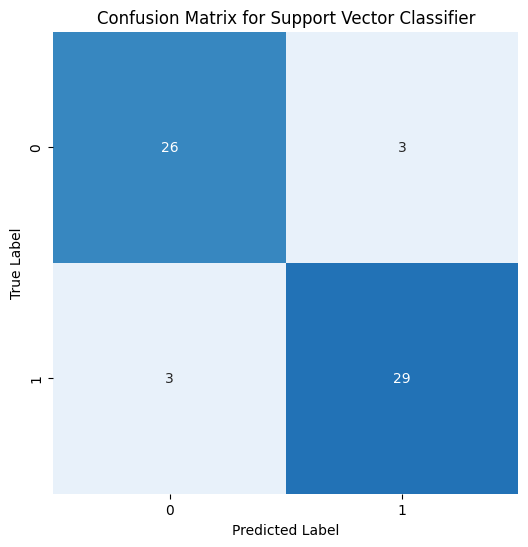

In [25]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    pipe = Pipeline([
        ('Transform', step1),  # You need to define the 'step1' transformer
        ('model', model),
    ])

    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)

    # Use appropriate classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred,  average="macro")
    f1 = f1_score(y_test, y_pred,  average="macro")

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, cm

# Initialize different classification models
models = {

     'Support Vector Classifier': SVC()

}

# Create a list to store the results
results = []

# Evaluate and print classification metrics for different models
for model_name, model in models.items():
    accuracy, precision, recall, f1, cm = evaluate_model(model, x_train, y_train, x_test, y_test)
    results.append([model_name, accuracy, precision, recall, f1, cm])

# Print the results in a tabular form
headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "Confusion Matrix"]
print(tabulate(results, headers, tablefmt="grid"))

max_accuracy_index = np.argmax([result[1] for result in results])
best_model_name = results[max_accuracy_index][0]
print(f"\nThe model with the highest accuracy is: {best_model_name} (Accuracy: {results[max_accuracy_index][1]:.4f})")
max_accuracy_index = np.argmax([result[1] for result in results])
best_model_name = results[max_accuracy_index][0]
# print(f"\nThe model with the highest accuracy is: {best_model_name} (Accuracy: {results[max_accuracy_index][1]:.4f})")

# Plot confusion matrix with class labels, emphasizing diagonals
plt.figure(figsize=(6, 6))
sns.heatmap(results[max_accuracy_index][-1], annot=True, fmt="d", cmap="Blues", cbar=False, vmin=0, vmax=results[max_accuracy_index][-1].diagonal().max()+10)
plt.title(f"Confusion Matrix for {best_model_name}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [26]:
from sklearn.model_selection import cross_val_score,KFold
pipe = Pipeline([
        ('Transform', step1),  # You need to define the 'step1' transformer
        ('model', model),
    ])

kf=KFold(n_splits=5)
score=cross_val_score(pipe,X,y,cv=kf)


print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))


Cross Validation Scores are [0.78688525 0.63934426 0.81967213 0.71666667 0.55      ]
Average Cross Validation score :0.7025136612021858


In [27]:
model

SVC()

In [28]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


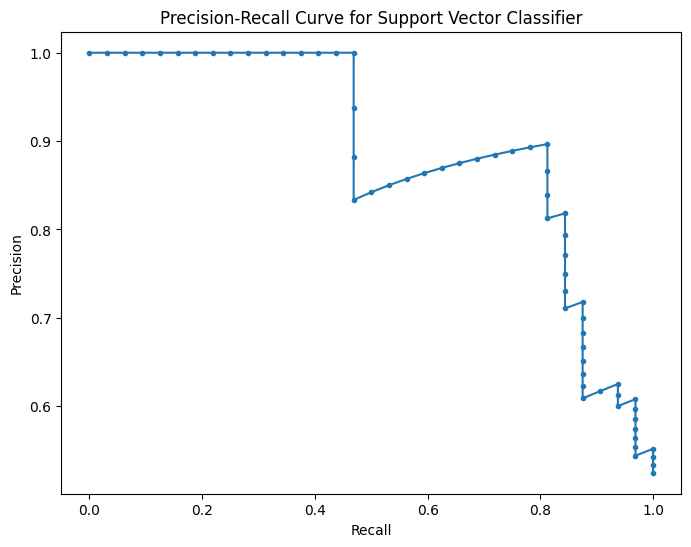

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


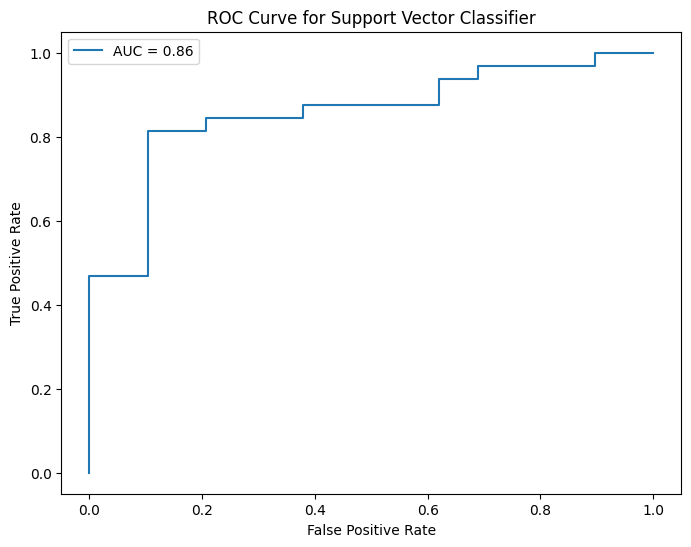

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# ... (previous code)

# Assuming 'step1' is your transformer
# Initialize SVM model with probability=True
model = SVC(probability=True)

# Fit the model on training data
model.fit(x_train, y_train)

# Create a pipeline
pipe = Pipeline([
    ('Transform', step1),
    ('model', model),
])

# Evaluate and print classification metrics for different models
for model_name, model in models.items():
    accuracy, precision, recall, f1, cm = evaluate_model(model, x_train, y_train, x_test, y_test)
    results.append([model_name, accuracy, precision, recall, f1, cm])

    # Plot Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, pipe.predict_proba(x_test)[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, marker='.')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, pipe.predict_proba(x_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

model = SVC()

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
}


# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)
